In [2]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [3]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [4]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.9
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 5400
Test set size: 600


In [5]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]

In [6]:
dim1_data = t_x_data
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()

In [7]:
def sliding_windows(data, seq_length, output_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-(1+output_length)):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+output_length)]
#         _y = data[(i+seq_length)]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

training_data = dim1_data_scaled.reshape(-1,1)

seq_length = 10
output_length = 20
x, y = sliding_windows(training_data, seq_length, output_length)

print(y[0])

train_test_ratio = 0.85
train_size = int(len(y) * train_test_ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX:",dataX.shape)
print("trainX:",trainX.shape)
print("testX:",testX.shape)
print("dataY:",dataY.shape)
print("trainY:",trainY.shape)
print("testY:",testY.shape)

[[-1.37243781]
 [-1.37034866]
 [-1.37408779]
 [-1.3723779 ]
 [-1.36772723]
 [-1.37081726]
 [-1.3759234 ]
 [-1.36756427]
 [-1.37343469]
 [-1.36675562]
 [-1.36954274]
 [-1.377528  ]
 [-1.35999815]
 [-1.37338873]
 [-1.3702089 ]
 [-1.37445999]
 [-1.36617058]
 [-1.36802747]
 [-1.36839466]
 [-1.36787913]]
dataX: torch.Size([5369, 10, 1])
trainX: torch.Size([4563, 10, 1])
testX: torch.Size([806, 10, 1])
dataY: torch.Size([5369, 20, 1])
trainY: torch.Size([4563, 20, 1])
testY: torch.Size([806, 20, 1])


In [8]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_length)

    def forward(self, x):
        # hidden and cell states
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Debugging
#         print("x",x.shape,"\n",x)
#         print("h_0",h_0.shape,"\n",h_0)
#         print("c_0",c_0.shape,"\n",c_0)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [9]:
torch.manual_seed(0)

num_epochs = 500
learning_rate = 0.01

input_size = 1
hidden_size = 20
num_layers = 1

lstm = LSTM(input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

print(lstm(trainX).size())
print(trainY.size())

# Train the model
for epoch in range(num_epochs):
#     print("training x shape:",trainX.shape)
    outputs = lstm(trainX).reshape(-1,output_length,1)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

torch.Size([4563, 20])
torch.Size([4563, 20, 1])
Epoch: 0, loss: 1.01142
Epoch: 50, loss: 0.13754
Epoch: 100, loss: 0.09643
Epoch: 150, loss: 0.08912
Epoch: 200, loss: 0.08598
Epoch: 250, loss: 0.08489
Epoch: 300, loss: 0.08376
Epoch: 350, loss: 0.08326
Epoch: 400, loss: 0.08352
Epoch: 450, loss: 0.08281


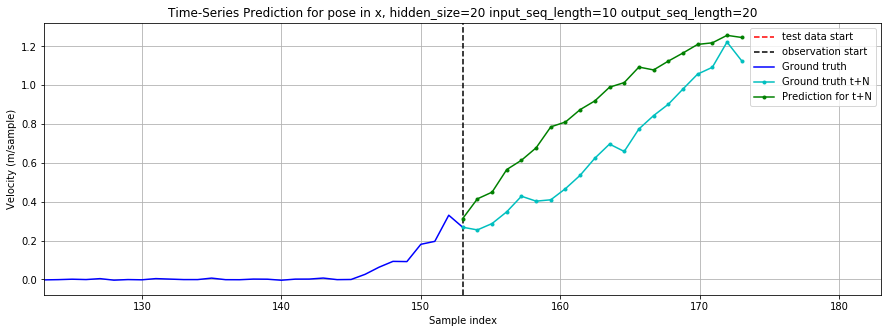

In [17]:
prediction_start_index = 153 #int(len(dataY)*train_test_ratio) + 10 #160

lstm.eval()
train_predict = lstm(dataX[[prediction_start_index]])

# Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
data_predict_rescaled = train_predict.data.numpy()*dim1_data.std()+dim1_data.mean()
dataY_full_rescaled = dataY.data.numpy()*dim1_data.std()+dim1_data.mean()
dataY_plot_rescaled = dataY[prediction_start_index].data.numpy()*dim1_data.std()+dim1_data.mean()

x_axis_ticks = np.linspace(prediction_start_index,prediction_start_index+output_length,output_length)

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
view_size = 30
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(dataY_full_rescaled[:prediction_start_index+1,0],'b-',label="Ground truth")
plt.plot(x_axis_ticks,dataY_plot_rescaled,'c.-',label="Ground truth t+N")
plt.plot(x_axis_ticks,data_predict_rescaled[0,:],'g.-',label="Prediction for t+N")

title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' input_seq_length='+str(seq_length) +' output_seq_length='+str(output_length)
plt.title(title_string)
plt.xlabel('Sample index')
plt.ylabel('Velocity (m/sample)')
plt.grid()
plt.legend()
plt.show()

In [11]:
def appender(input_seq,new_val):
    """
    Append value to input sequence (treat as arrays)
    """
    input_seq = np.delete(input_seq,0)
    updated_input_seq = np.append(input_seq,new_val)
    return updated_input_seq
my_arr = np.array([0,2,4,6])
print(my_arr)
my_new_arr = appender(my_arr,8)
print(my_new_arr)

[0 2 4 6]
[2 4 6 8]


In [12]:
import datetime
from time import strftime
print(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

save_plots = False
prediction_start_index = 150 #int(len(dataY)*train_test_ratio) - 50#140 #140
# prediction_horizon = 100
num_frames_to_render = 100
experiment_dir = '/workspace/data/pose-prediction-odometry/'+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
if save_plots:
    os.mkdir(experiment_dir)
    for frame in range(prediction_start_index,prediction_start_index+num_frames_to_render):
        prediction_start_index = frame
        
#         input_seq = dataX[prediction_start_index]
#         future_val = dataY.data.numpy()[prediction_start_index][0]

#         output_collection = lstm(dataX[[prediction_start_index]])

#         for i in range(prediction_horizon):
#             updated_input_seq = appender(input_seq,future_val)
#             updated_input_seq = updated_input_seq[np.newaxis,...,np.newaxis]
#             updated_input_seq = Variable(torch.tensor(updated_input_seq))

#             next_prediction = lstm(updated_input_seq)
#             output_collection = torch.cat((output_collection, next_prediction), 0)

#             # Update states
#             input_seq = updated_input_seq
#             future_val = next_prediction.data.numpy()
           
#         predictions = output_collection

        lstm.eval()
        predictions = lstm(dataX[[prediction_start_index]])

        # Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
        data_predict_rescaled = predictions.data.numpy()*dim1_data.std()+dim1_data.mean()
        dataY_full_rescaled = dataY.data.numpy()*dim1_data.std()+dim1_data.mean()
        dataY_plot_rescaled = dataY[prediction_start_index].data.numpy()*dim1_data.std()+dim1_data.mean()
        x_axis_ticks = np.linspace(prediction_start_index,prediction_start_index+output_length,output_length)
        
        fig = plt.figure(figsize=(15,5))
        plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
        plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
        view_size = 150
        x_centre = prediction_start_index #len(dataY)*train_test_ratio
        plt.xlim(x_centre-view_size,x_centre+view_size)
        plt.ylim(-0.5,3)
        plt.plot(dataY_full_rescaled[:prediction_start_index+1,0],'b-',label="Ground truth")
        plt.plot(x_axis_ticks,dataY_plot_rescaled,'c.-',label="Ground truth t+N")
        plt.plot(x_axis_ticks,data_predict_rescaled[0,:],'g.-',label="Prediction for t+N")
        
#         plt.plot(dataY_plot_rescaled,label="Ground truth")
#         plt.plot(x_axis_ticks,data_predict_rescaled,label="LSTM Prediction")
        title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
                     +' input_seq_length='+str(seq_length) +' output_seq_length='+str(output_length)
        plt.title(title_string)
        plt.xlabel('Sample index')
        plt.ylabel('Velocity (m/sample)')
        plt.grid()
        plt.legend()
        plt.savefig("%s%s%i%s%i%s" % (experiment_dir,'/hiddensize-',hidden_size,'-frame-',frame,'.png'), \
                    bbox_inches='tight')
        plt.close(fig)

04-06-2020-10-16-58
